# **Survivors on Titanic prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("Data_Titanic.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## <font color=black> Variable Description </font>
- PassengerId: <font color=black> passenger's **ID** </font> 
- Survived: <font color=black> **0** </font>= No, <font color=black> **1** </font>= Yes
- PClass: Passenger Class=<font color=black> (1=**1st**. 2=**2nd**,3=**3rd**) </font>
- Name: <font color=black> passenger's **name** </font> 
- Sex: <font color=black> passenger's **sex** </font> 
- Age: <font color=black> passenger's **age** </font> 
- SibSp: <font color=black> **number** of Siblings/Spouses Aboard </font> 
- Parch: <font color=black> **number** of Parents/Children Aboard </font>
- Ticket: <font color=black> **Ticket number** </font> 
- Fare: <font color=black> **Passenger Fare** (British pound) </font> 
- Cabin: <font color=black> **Cabin ID** </font> 
- Embarked: <font color=black> **Port of Embarkation** </font> C=Cherbourg, Q=Queenstown, S=Southampton

# **Data analysis and features engineering**

In [4]:
df.shape

(891, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#Numerical features
numerical = df.select_dtypes(include=np.number).columns.tolist()
print(numerical)
categorical = df.select_dtypes(exclude=np.number).columns.tolist()
print(categorical)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


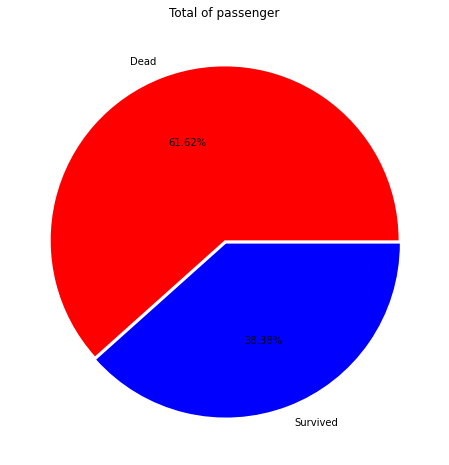

In [8]:
#Survived and dead
plt.figure(figsize=(8,8))
plt.pie(df["Survived"].value_counts(), colors=["red", "blue"], labels=["Dead","Survived"], autopct='%.2f%%', explode=[0,0.02] )
plt.title("Total of passenger");

In [9]:
#Replace cabin number with prefix and fill null values with "X"
df["Cabin"]=pd.Series([i[0] if not pd.isnull(i) else "X" for i in df["Cabin"]])

<AxesSubplot:xlabel='Cabin', ylabel='count'>

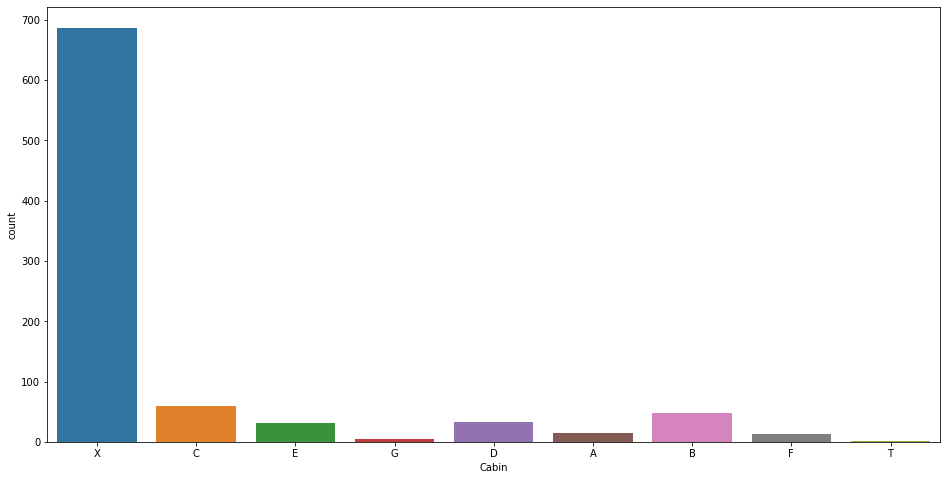

In [10]:
plt.figure(figsize=(16,8))
sns.countplot(df["Cabin"])

Text(6.799999999999997, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

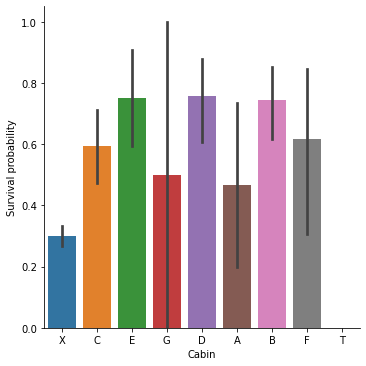

In [11]:
plt.figure(figsize=(16,8))
sns.factorplot(x="Cabin",y="Survived", data=df, kind="bar")
plt.ylabel("Survival probability")

Text(0, 0.5, 'Survival probability')

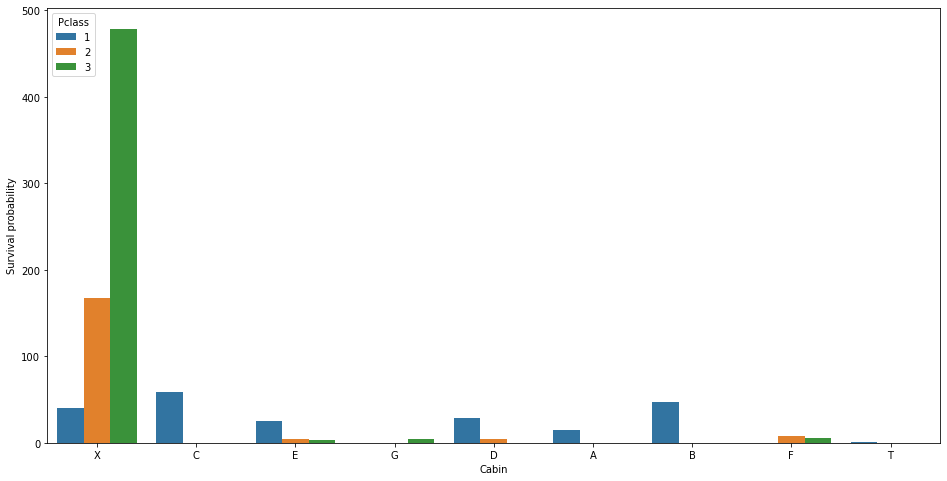

In [12]:
#Pclass and survived by sex
plt.figure(figsize=(16,8))
sns.countplot(x='Cabin', hue='Pclass', data=df)
plt.ylabel("Survival probability")

In [13]:
df.groupby(['Cabin', 'Pclass']).size()

Cabin  Pclass
A      1          15
B      1          47
C      1          59
D      1          29
       2           4
E      1          25
       2           4
       3           3
F      2           8
       3           5
G      3           4
T      1           1
X      1          40
       2         168
       3         479
dtype: int64

In [14]:
#Grouping Cabin based on Pclass
df['Cabin'] = df['Cabin'].replace(['A', 'B', 'C', 'T'],'ABC')
df['Cabin'] = df['Cabin'].replace(['D', 'E'], 'DE')
df['Cabin'] = df['Cabin'].replace(['F', 'G'], 'FG')

In [15]:
#Dummies variables "Cabin" 
df = pd.get_dummies(df, columns=['Cabin'])

In [16]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Cabin_ABC        0
Cabin_DE         0
Cabin_FG         0
Cabin_X          0
dtype: int64

<AxesSubplot:title={'center':'Fare boxplot'}, xlabel='Fare'>

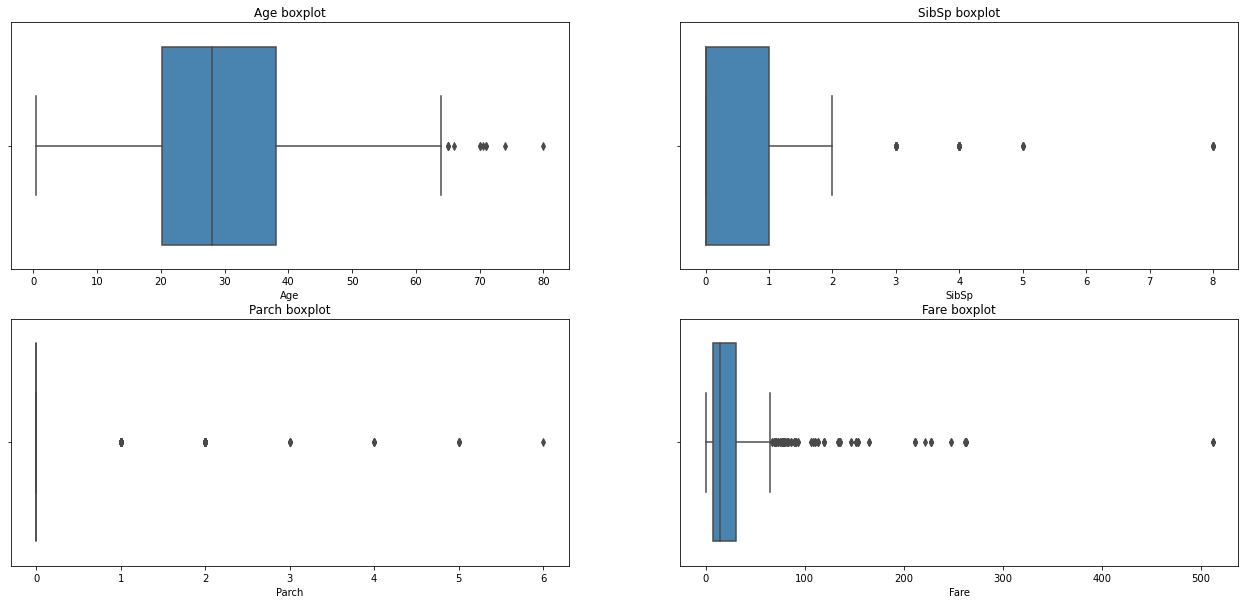

In [17]:
#Outlier detection
plt.figure(figsize=(22,10))

plt.subplot(2,2,1)
plt.title("Age boxplot")
sns.boxplot(x=df.Age, palette="Blues_d")

plt.subplot(2,2,2)
plt.title("SibSp boxplot")
sns.boxplot(x=df.SibSp, palette="Blues_d")

plt.subplot(2,2,3)
plt.title("Parch boxplot")
sns.boxplot(x=df.Parch, palette="Blues_d")

plt.subplot(2,2,4)
plt.title("Fare boxplot")
sns.boxplot(x=df.Fare, palette="Blues_d")



In [18]:
print(np.where(df['Fare']>500))
print(np.where(df["SibSp"]>=8))

(array([258, 679, 737], dtype=int64),)
(array([159, 180, 201, 324, 792, 846, 863], dtype=int64),)


In [19]:
df.drop(df.index[[258, 679, 737,159, 180, 201, 324, 792, 846, 863]], inplace=True)

<AxesSubplot:>

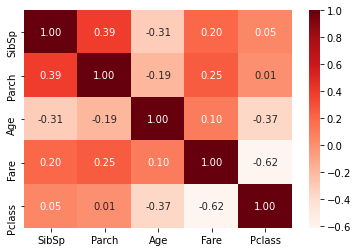

In [20]:
#Correlation matrix between numerical features 
sns.heatmap(df[["SibSp","Parch","Age","Fare","Pclass"]].corr(), fmt= ".2f", annot=True, cmap="Reds")

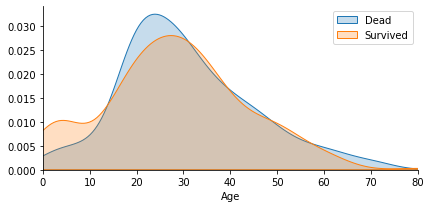

In [21]:
#Age
facet = sns.FacetGrid(df, hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Age", shade=True)
facet.set(xlim=(0, df["Age"].max()))
plt.legend(loc="upper right", labels=["Dead","Survived"]);

In [22]:
# Fill Age missin values with the median age of similar rows according to the most correlated
df['Age'] = df.groupby(['Pclass','SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))

In [23]:
#Grouping Age
df["Age"] = df["Age"].astype(int)
df.loc[(df['Age'] <= 2), 'Age Group'] = 'Baby' 
df.loc[((df["Age"] > 2) & (df['Age'] <= 10)), 'Age Group'] = 'Child' 
df.loc[((df["Age"] > 10) & (df['Age'] <= 19)), 'Age Group'] = 'Young Adult'
df.loc[((df["Age"] > 19) & (df['Age'] <= 60)), 'Age Group'] = 'Adult'
df.loc[(df["Age"] > 60), 'Age Group'] = 'Senior'

In [24]:
df = pd.get_dummies(df, columns=['Age Group'])

Text(6.799999999999997, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

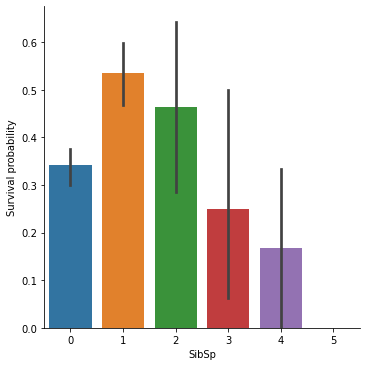

In [25]:
#SibSp
plt.figure(figsize=(16,8))
sns.factorplot(x="SibSp",y="Survived", data=df, kind="bar")
plt.ylabel("Survival probability")

Text(6.799999999999997, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

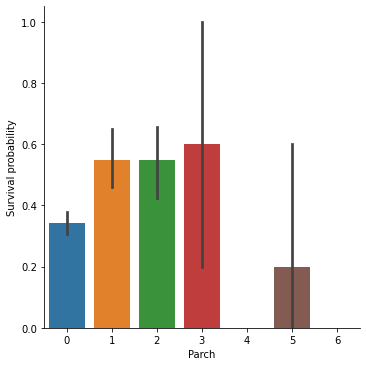

In [26]:
#Parch
plt.figure(figsize=(16,8))
sns.factorplot(x="Parch",y="Survived", data=df, kind="bar")
plt.ylabel("Survival probability")

<AxesSubplot:xlabel='Fare', ylabel='Density'>

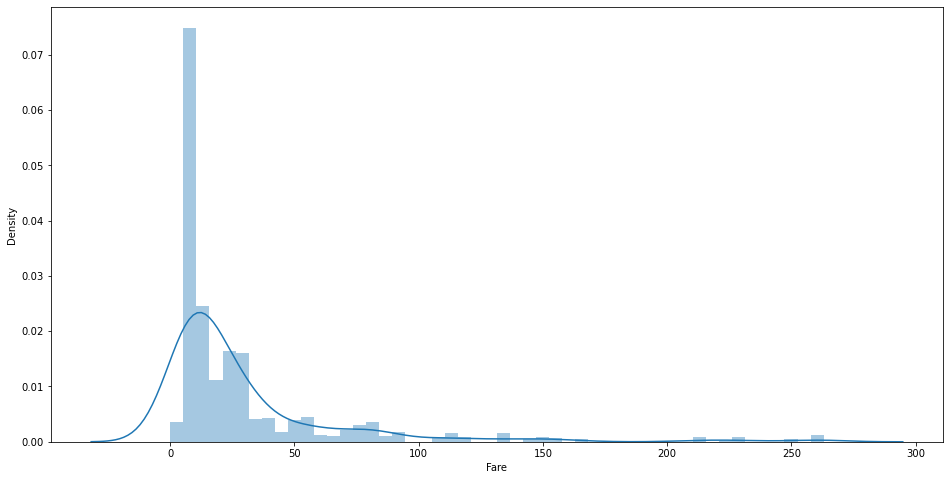

In [27]:
#Fare
df["Fare"]=df["Fare"].fillna(df["Fare"].median())
plt.figure(figsize=(16,8))
sns.distplot(df["Fare"])

<AxesSubplot:xlabel='Fare', ylabel='Density'>

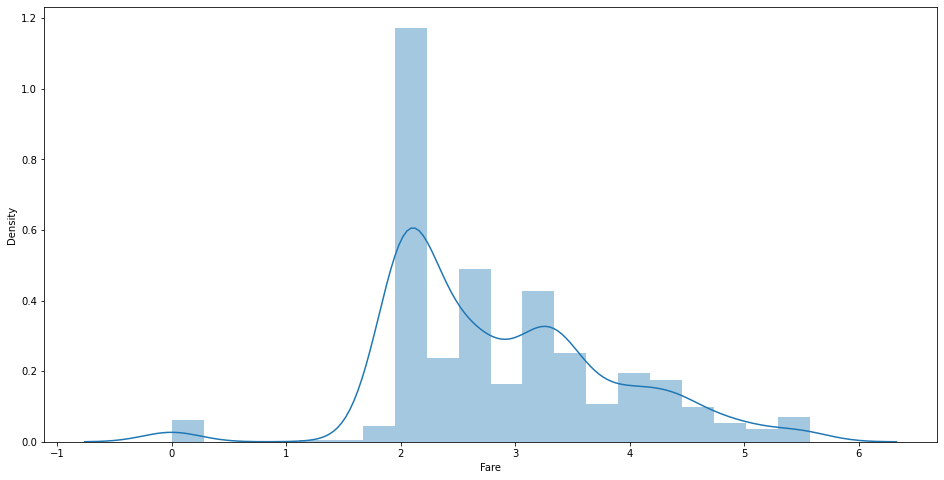

In [28]:
#Apply log to Fare distribution
df["Fare"]= df["Fare"].map(lambda i : np.log(i) if i>0 else 0)
plt.figure(figsize=(16,8))
sns.distplot(df["Fare"])

Text(6.799999999999997, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

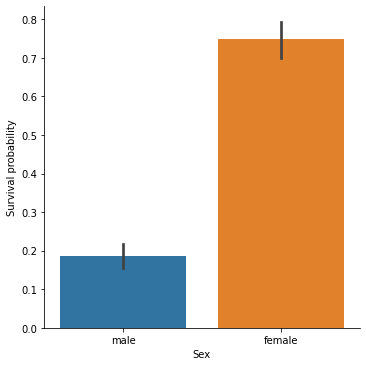

In [29]:
#Sex
plt.figure(figsize=(16,8))
sns.factorplot(x="Sex",y="Survived", data=df, kind="bar")
plt.ylabel("Survival probability")

In [30]:
#Convert sex into categorical
df["Sex"] = df["Sex"].map({"male": 0, "female":1})

Text(6.799999999999997, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

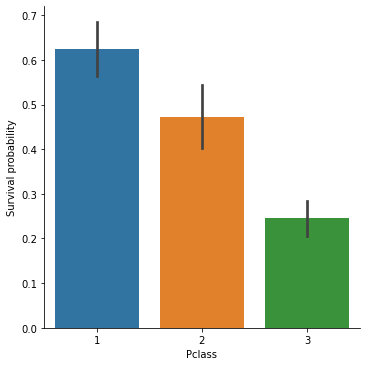

In [31]:
#Pclass
plt.figure(figsize=(16,8))
sns.factorplot(x="Pclass",y="Survived", data=df, kind="bar")
plt.ylabel("Survival probability")

Text(10.778541666666662, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

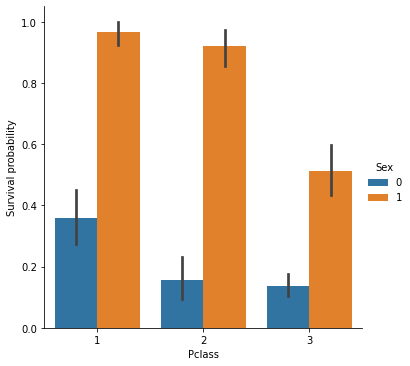

In [32]:
#Pclass and survived by sex
plt.figure(figsize=(16,8))
sns.factorplot(x="Pclass",y="Survived", hue="Sex", data=df, kind="bar")
plt.ylabel("Survival probability")

In [33]:
#Embarked
df["Embarked"].isnull().sum()

2

In [34]:
df["Embarked"].value_counts()

S    637
C    165
Q     77
Name: Embarked, dtype: int64

In [35]:
#Embarked
df["Embarked"]=df["Embarked"].fillna("S")

Text(6.799999999999997, 0.5, 'Survival probability')

<Figure size 1152x576 with 0 Axes>

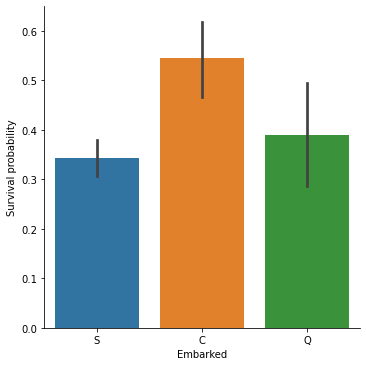

In [36]:
plt.figure(figsize=(16,8))
sns.factorplot(x="Embarked",y="Survived", data=df, kind="bar")
plt.ylabel("Survival probability")

In [37]:
#Dummies variables "Embarked" and "Pclass"
df = pd.get_dummies(df, columns=['Embarked','Pclass'])

In [38]:
df["Family members"]= df["SibSp"]+df["Parch"]+1

In [39]:
#Name
df["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [40]:
# Get Title from Name
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
df["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

<AxesSubplot:xlabel='Title', ylabel='count'>

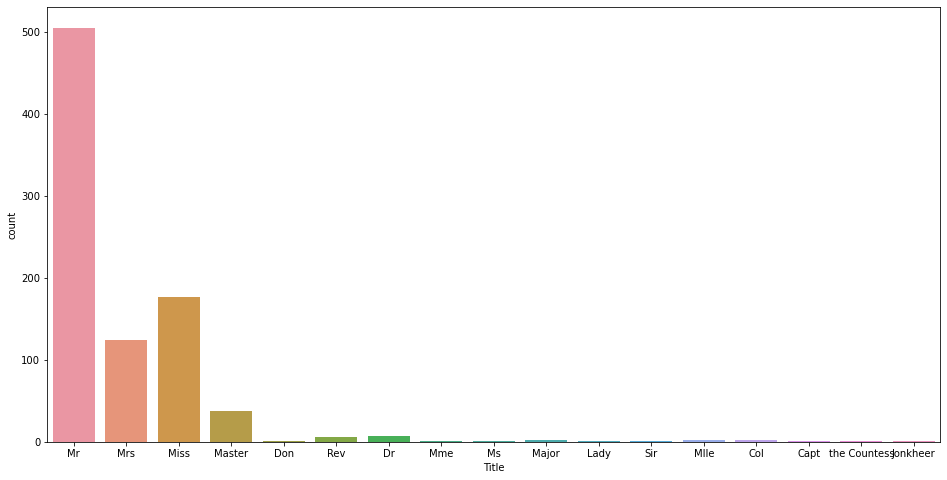

In [41]:
plt.figure(figsize=(16,8))
sns.countplot(x="Title",data=df)

In [42]:
#Group rare title 
df["Title"] = df["Title"].replace(['Capt', 'Col', 'Major', 'Dr'], 'Officer')
df["Title"] = df["Title"].replace(['Don', 'Sir', 'the Countess', 'Dona', 'Lady','Jonkheer'], 'Royalty')
df["Title"] = df["Title"].replace(['Mme', 'Ms', 'Mrs','Mlle'], 'Miss')
df["Title"] = df["Title"].replace(['Master','Rev'], 'Master')
df["Title"].value_counts()

Mr         505
Miss       305
Master      44
Officer     12
Royalty      5
Name: Title, dtype: int64

In [43]:
#Dummies variables "Title" 
df = pd.get_dummies(df, columns=['Title'])

In [44]:
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')

In [45]:
df['Surname'] = df['Name'].map(lambda i: i.split(',')[0])

In [46]:
df['Family_Survival'] = 0.385

'''
Check for all the people with families as to how many people survived from that family
This is their average survival rate..  sr = (survived / total family members)
'''
for gid, gdf in df.groupby('Surname'):
    if len(gdf) > 1:
        for i, r in gdf.iterrows():
            fam = gdf.drop(i)
            sur = list(fam['Survived'])
            ans = np.nanmean(sur)
            if not math.isnan(ans):
                df.loc[df['PassengerId'] == r['PassengerId'], 'Family_Survival'] = ans

                
# We do the same as above except in this case it is with ticket frequency, number of people having the same ticket  
df['Ticket_Survival'] = 0.385

for gid, gdf in df.groupby('Ticket'):
    if len(gdf) > 1:
        for i, r in gdf.iterrows():
            fam = gdf.drop(i)
            sur = list(fam['Survived'])
            ans = np.nanmean(sur)
            if not math.isnan(ans):
                df.loc[df['PassengerId'] == r['PassengerId'], 'Ticket_Survival'] = ans

'''
Average survival rate of a particular person 
based on their family survival rate and their ticket survival rate
'''
num = (df["Family members"] * df['Family_Survival']) + (df['Ticket_Frequency'] * df['Ticket_Survival'])
den = df['Family members'] + df['Ticket_Frequency']
df['Survival'] = num / den

In [47]:
df.drop(labels = ["Name","PassengerId","Age","Ticket","Ticket_Frequency","Family_Survival","Ticket_Survival","Surname","Parch","SibSp"], axis = 1, inplace = True)

In [48]:
scaler= StandardScaler()
df[['Family members','Fare']] = scaler.fit_transform(df[['Family members','Fare']])

In [49]:
pd.get_option("display.max_columns",None)
df

,Survived,Sex,Fare,Cabin_ABC,Cabin_DE,Cabin_FG,Cabin_X,Age Group_Adult,Age Group_Baby,Age Group_Child,...,Pclass_1,Pclass_2,Pclass_3,Family members,Title_Master,Title_Miss,Title_Mr,Title_Officer,Title_Royalty,Survival
0,0,0,-0.907670,0,0,0,1,1,0,0,...,0,0,1,0.118199,0,0,1,0,0,0.128333
1,1,1,1.421429,1,0,0,0,1,0,0,...,1,0,0,0.118199,0,1,0,0,0,0.385000
2,1,1,-0.816958,0,0,0,1,1,0,0,...,0,0,1,-0.595045,0,1,0,0,0,0.385000
3,1,1,1.121347,1,0,0,0,1,0,0,...,1,0,0,0.118199,0,1,0,0,0,0.000000
4,0,0,-0.801010,0,0,0,1,1,0,0,...,0,0,1,-0.595045,0,0,1,0,0,0.692500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,-0.312624,0,0,0,1,1,0,0,...,0,1,0,-0.595045,0,0,0,0,0,0.385000
887,1,1,0.539516,1,0,0,0,0,0,0,...,1,0,0,-0.595045,0,0,0,0,0,0.442500
888,0,1,0.288508,0,0,0,1,1,0,0,...,0,0,1,1.544689,0,0,0,0,0,0.000000
889,1,0,0.539516,1,0,0,0,1,0,0,...,1,0,0,-0.595045,0,0,0,0,0,0.385000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 890
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survived               881 non-null    int64  
 1   Sex                    881 non-null    int64  
 2   Fare                   881 non-null    float64
 3   Cabin_ABC              881 non-null    uint8  
 4   Cabin_DE               881 non-null    uint8  
 5   Cabin_FG               881 non-null    uint8  
 6   Cabin_X                881 non-null    uint8  
 7   Age Group_Adult        881 non-null    uint8  
 8   Age Group_Baby         881 non-null    uint8  
 9   Age Group_Child        881 non-null    uint8  
 10  Age Group_Senior       881 non-null    uint8  
 11  Age Group_Young Adult  881 non-null    uint8  
 12  Embarked_C             881 non-null    uint8  
 13  Embarked_Q             881 non-null    uint8  
 14  Embarked_S             881 non-null    uint8  
 15  Pclass

# **Modeling**

In [51]:
X= df.loc[:, df.columns != 'Survived'].values
y= df.loc[:, df.columns == 'Survived'].values.squeeze()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.2, stratify=y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((704, 24), (177, 24), (704,), (177,))

In [53]:
score_fnc= balanced_accuracy_score
rn=24
kfold = StratifiedKFold(n_splits=5, random_state=rn)

In [54]:
#SUPPORT VECTOR MACHINE
param_grid_SVC= {'kernel':['poly'],'C': loguniform(1e-2,1e3), 'degree': [2,3,4]}
svc = svm.SVC(class_weight="balanced")
rsSVC= RandomizedSearchCV(estimator=svc, param_distributions=param_grid_SVC, scoring=make_scorer(score_fnc),cv=kfold, n_iter=250, n_jobs=-1, verbose=1)
rsSVC.fit(X_train,y_train)
SVC_best = rsSVC.best_estimator_
rsSVC.best_score_, rsSVC.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1113 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:   25.2s finished


(0.7973715773074235, {'C': 1.1106657130809137, 'degree': 3, 'kernel': 'poly'})

In [55]:
#EXTRATREE
param_grid_ETC= {"max_depth": [None],"max_features":np.arange(1,25),"min_samples_split": [2,3,7,10,12],"min_samples_leaf": [1,3,7,10],
              "bootstrap": [False,True],"n_estimators" :[300,400,500],"criterion": ["gini","entropy"]}
ETC = ExtraTreesClassifier(class_weight="balanced")
rsETC= RandomizedSearchCV(estimator=ETC, param_distributions=param_grid_ETC, scoring=make_scorer(score_fnc),cv=kfold, n_iter=250, n_jobs=-1, verbose=1)
rsETC.fit(X_train,y_train)
ETC_best = rsETC.best_estimator_
rsETC.best_score_, rsETC.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  6.8min finished


(0.8144243558277239,
 {'n_estimators': 300,
  'min_samples_split': 10,
  'min_samples_leaf': 1,
  'max_features': 10,
  'max_depth': None,
  'criterion': 'gini',
  'bootstrap': False})

In [56]:
#CATBOOST
param_grid_CB= {'depth': [2,3,4,5,6,7,8],'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4],'n_estimators':[300,400,500,600],
               'l2_leaf_reg':[1,3,5,10,20,30]}
CB = CatBoostClassifier(verbose=0,auto_class_weights="Balanced")
rsCB= RandomizedSearchCV(estimator=CB, param_distributions=param_grid_CB, scoring=make_scorer(score_fnc),cv=kfold, n_iter=250, n_jobs=-1, verbose=1)
rsCB.fit(X_train,y_train)
CB_best = rsCB.best_estimator_
rsCB.best_score_, rsCB.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  6.8min finished


(0.8225678598332969,
 {'n_estimators': 600, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'depth': 7})

In [57]:
#RANDOM FOREST
param_grid_RF= {"max_features":np.arange(1,25), "n_estimators": np.arange(200,400,5),"min_samples_leaf":[1, 3, 7, 10],
               "criterion":["gini","entropy"],"bootstrap":["True","False"],"min_samples_split":[2,3,4,5,6]}
RF = RandomForestClassifier(class_weight="balanced")
rsRF= RandomizedSearchCV(estimator=RF, param_distributions=param_grid_RF , scoring=make_scorer(score_fnc), cv=kfold, n_iter=250, n_jobs=-1, verbose=1)
rsRF.fit(X_train,y_train)
RF_best = rsRF.best_estimator_
rsRF.best_score_, rsRF.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  5.4min finished


(0.8223054927786283,
 {'n_estimators': 315,
  'min_samples_split': 6,
  'min_samples_leaf': 3,
  'max_features': 6,
  'criterion': 'gini',
  'bootstrap': 'True'})

In [58]:
#GBC
gb_param_grid = {'loss':["deviance","exponential"],'n_estimators' : [300,400,500],'learning_rate': [0.3,0.2, 0.1, 0.05, 0.01, 0.001],
                 'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14],'min_samples_leaf': [25,50,100,150,250],'max_features': [0.9,0.7,0.5,0.3]}
GBC = GradientBoostingClassifier()
rsGBC = RandomizedSearchCV(estimator=GBC, param_distributions=gb_param_grid , scoring=make_scorer(score_fnc), cv=kfold, n_iter=250, n_jobs=-1, verbose=1)
rsGBC.fit(X_train,y_train)
GBC_best = rsGBC.best_estimator_
rsGBC.best_score_, rsGBC.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  2.8min finished


(0.8042810354277876,
 {'n_estimators': 500,
  'min_samples_leaf': 100,
  'max_features': 0.3,
  'max_depth': 4,
  'loss': 'deviance',
  'learning_rate': 0.1})

In [59]:
#ADABOOST
DTC = DecisionTreeClassifier(class_weight="balanced")
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],"base_estimator__splitter" : ["best", "random"],"algorithm" : ["SAMME","SAMME.R"], 
                  "base_estimator__max_depth": np.arange(1,50), "n_estimators" :[40,50,60,70],"learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.2,1.5]}
adaDTC = AdaBoostClassifier(DTC)
rsADA = RandomizedSearchCV(adaDTC,param_distributions = ada_param_grid, scoring=make_scorer(score_fnc), cv=kfold, n_iter=250, n_jobs=-1, verbose=1)
rsADA.fit(X_train,y_train)
ADA_best = rsADA.best_estimator_
rsADA.best_score_, rsADA.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1243 out of 1250 | elapsed:  1.4min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  1.4min finished


(0.8109429229477346,
 {'n_estimators': 50,
  'learning_rate': 0.1,
  'base_estimator__splitter': 'best',
  'base_estimator__max_depth': 3,
  'base_estimator__criterion': 'gini',
  'algorithm': 'SAMME.R'})

In [61]:
#LOGISTIC REGRESSION
param_grid_lr= {"penalty": ["l1","l2"],'C': loguniform(1e-3,1e3)}
LR = LogisticRegression(solver="liblinear")
rsLR= RandomizedSearchCV(estimator=LR, param_distributions=param_grid_lr , scoring=make_scorer(score_fnc), 
                                    cv=kfold, n_iter=250, verbose=1, n_jobs=-1)
rsLR.fit(X_train,y_train)
LR_best = rsLR.best_estimator_
rsLR.best_score_, rsLR.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:    9.1s finished


(0.7865728657869797, {'C': 0.47324302932360485, 'penalty': 'l2'})

In [62]:
#I choose a voting classifier to combine the predictions from these models
RF_best, GBC_best, CB_best, ADA_best, ETC_best, LR_best, SVC_best

(RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=None, max_features=6,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=6,
                        min_weight_fraction_leaf=0.0, n_estimators=315,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=4,
                            max_features=0.3, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=100, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estima

In [63]:
#Ensemble modeling
votingC = VotingClassifier(estimators=[('svc', SVC_best), ('rf', RF_best),('lr', LR_best), ('gbc',GBC_best), ('ada',ADA_best),('et',ETC_best),('cb',CB_best)], voting='hard', n_jobs=-1)
votingC = votingC.fit(X_train, y_train)

In [64]:
#Preditcion
prediction=votingC.predict(X_test)
result=balanced_accuracy_score(prediction,y_test)
print(round(result,5))

0.85993


In [65]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       109
           1       0.84      0.79      0.82        68

    accuracy                           0.86       177
   macro avg       0.86      0.85      0.86       177
weighted avg       0.86      0.86      0.86       177

